# Исследовательский анализ "Яндекс Афиша"

## 1. Цели
> **Заполнить!**

## 2. Описание
> **Заполнить!**

## 3. Содержимое

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

## 4. Загрузка данных и их предобработка

### 4.1 Импорт библиотек

In [ ]:
import marimo as mo
import pandas as pd
from phik import phik_matrix

### 4.2 Выгружаем датафрейм из БД (1.1)

In [ ]:
# Выгрузка из БД

import psycopg2  # библиотека для подключения к PostgreSQL
import os        # модуль для работы с переменными окружения
from dotenv import load_dotenv  # функция для загрузки переменных окружения из .env файла

# Загружаем переменные окружения из файла .env в текущую среду
# Это позволяет не хранить логины и пароли прямо в коде
load_dotenv()

# Устанавливаем соединение с базой данных PostgreSQL
# Параметры подключения берутся из переменных окружения:
# PGHOST — хост базы данных
# PGPORT — порт
# PGDATABASE — имя базы данных
# PGUSER — пользователь
# PGPASSWORD — пароль
conn = psycopg2.connect(
    host=os.getenv("PGHOST"),
    port=os.getenv("PGPORT"),
    dbname=os.getenv("PGDATABASE"),
    user=os.getenv("PGUSER"),
    password=os.getenv("PGPASSWORD"),
)

# Откатываем возможную незавершённую транзакцию
conn.rollback()


# Функция для загрузки SQL-запроса из файла
# path — путь к файлу .sql
# возвращает строку с SQL-запросом
def load_sql(path: str) -> str:
    with open(path, "r") as f:
        return f.read()


# Загружаем SQL-запрос из файла витрины данных
# В данном случае — витрина покупок пользователей Афиши
query = load_sql("sql/marts/afisha_purchases_mart.sql")


# Выполняем SQL-запрос и загружаем результат в pandas DataFrame,
# затем сохраняем результат в CSV файл
# datasets/dataset.csv — файл, который будет использоваться далее для анализа
pd.read_sql(query, conn).to_csv('datasets/dataset.csv')


# Позже этот CSV можно загрузить обратно в DataFrame для анализа:
# df = pd.read_csv('datasets/dataset.csv')

### 4.3 Изучение общей информации о выгруженных данных (1.2)

In [ ]:
df_original = pd.read_csv('datasets/dataset.csv')
df = df_original.copy()

In [ ]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             290849 non-null  int64  
 1   user_id                290849 non-null  str    
 2   device_type_canonical  290849 non-null  str    
 3   order_id               290849 non-null  int64  
 4   order_dt               290849 non-null  str    
 5   order_ts               290849 non-null  str    
 6   currency_code          290849 non-null  str    
 7   revenue                290849 non-null  float64
 8   tickets_count          290849 non-null  int64  
 9   days_since_prev        268909 non-null  float64
 10  event_id               290849 non-null  int64  
 11  event_type_main        290849 non-null  str    
 12  service_name           290849 non-null  str    
 13  region_name            290849 non-null  str    
 14  city_name              290849 non-null  str    

In [ ]:
# Выведем данные с начала и с конца датафрейма
df.head(), df.tail()

In [ ]:
# Функция тестирования датафрейма на валидность
def validate_dataset(df: pd.DataFrame) -> None:
    """
    Проверка корректности выгруженного датасета.
    Останавливает выполнение при обнаружении критических ошибок.
    """

    print("Запуск проверки датасета.")

    # Проверка, что датафрейм не пустой
    if df.empty:
        raise ValueError("Датасет пустой")
    print("Тест 1 пройден: датафрейм не пустой")

    # Проверка структуры (колонки)
    expected_columns = {
        'user_id',
        'device_type_canonical',
        'order_id',
        'order_dt',
        'order_ts',
        'currency_code',
        'revenue',
        'tickets_count',
        'days_since_prev',
        'event_id',
        'event_type_main',
        'service_name',
        'region_name',
        'city_name'
    }

    missing_columns = expected_columns - set(df.columns)

    if missing_columns:
        raise ValueError(f"Отсутствуют колонки: {missing_columns}")
    print("Тест 2 пройден: структура датафрейма корректна")

    # Проверка на дубликаты ключа
    duplicate_count = df['order_id'].duplicated().sum()

    if duplicate_count > 0:
        raise ValueError(f"Обнаружено {duplicate_count} дубликатов order_id")
    print("Тест 3 пройден: дубликаты order_id отсутствуют")

    # Проверка revenue
    if (df['revenue'] < 0).any():
        raise ValueError("Обнаружена отрицательная revenue")
    print("Тест 4 пройден: revenue не содержит отрицательных значений")

    # Проверка tickets_count
    if (df['tickets_count'] <= 0).any():
        raise ValueError("Обнаружен tickets_count <= 0")
    print("Тест 5 пройден: tickets_count > 0 для всех строк")

    # Проверка device_type
    valid_devices = {'mobile', 'desktop'}

    invalid_devices = set(df['device_type_canonical']) - valid_devices

    if invalid_devices:
        raise ValueError(f"Некорректные device_type: {invalid_devices}")
    print("Тест 6 пройден: device_type_canonical содержит только допустимые значения")

    # Проверка дат
    order_dt_parsed = pd.to_datetime(df['order_dt'], errors='coerce')
    order_ts_parsed = pd.to_datetime(df['order_ts'], errors='coerce')

    if order_dt_parsed.isna().any():
        raise ValueError("Некорректные значения в order_dt")
    print("Тест 7 пройден: order_dt корректно парсится в дату")

    if order_ts_parsed.isna().any():
        raise ValueError("Некорректные значения в order_ts")
    print("Тест 8 пройден: order_ts корректно парсится в datetime")

    # Проверка days_since_prev
    days_parsed = pd.to_numeric(df['days_since_prev'], errors='coerce')

    invalid_days = df['days_since_prev'].notna() & days_parsed.isna()

    if invalid_days.any():
        raise ValueError("Обнаружены некорректные значения в days_since_prev")
    print("Тест 9 пройден: days_since_prev содержит только числовые значения или NULL")

    print("Проверка датасета успешно пройдена.")

In [ ]:
# Проверим датасет на валидность 1
#validate_dataset(df)

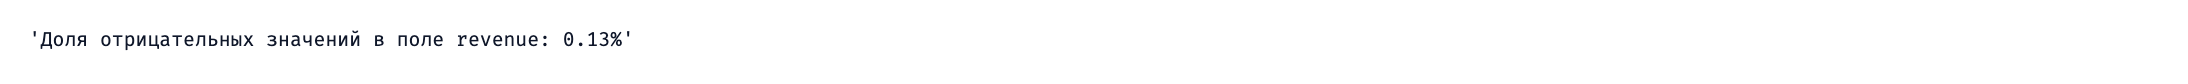

In [ ]:
# Обработка отрицательного revenue 
f'Доля отрицательных значений в поле revenue: {round(df[df['revenue'] < 0].shape[0] * 100 / df.shape[0], 2)}%'

Доля отрицательных значений в поле revenue `<5%` от общего объема и составляет `0.13%`. Следовательно, мы можем избавиться от аномальных записей.

In [ ]:
#Находим индексы строк с отрицательным revenue
bad_idx = df.index[df["revenue"] < 0]

# Удаляем их из df + сбрасываем индекс
df.drop(index=bad_idx, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Проверим датасет на валидность 2
validate_dataset(df)

Запуск проверки датасета.
Тест 1 пройден: датафрейм не пустой
Тест 2 пройден: структура датафрейма корректна
Тест 3 пройден: дубликаты order_id отсутствуют
Тест 4 пройден: revenue не содержит отрицательных значений
Тест 5 пройден: tickets_count > 0 для всех строк
Тест 6 пройден: device_type_canonical содержит только допустимые значения
Тест 7 пройден: order_dt корректно парсится в дату
Тест 8 пройден: order_ts корректно парсится в datetime
Тест 9 пройден: days_since_prev содержит только числовые значения или NULL
Проверка датасета успешно пройдена.


**Промежуточный вывод:**

1. **Объём и структура данных.**
Мы успешно загрузили датасет, который содержит 290 849 записей и 15 колонок (~33.3 mb). Структура данных соответствует ожидаемой, все необходимые признаки присутствуют. Типы данных корректны и позволяют проводить дальнейший анализ.

2. **Качество данных.**
В ходе первичного анализа мы обнаружили пропуски только в поле `days_since_prev`. Это ожидаемо, поскольку для пользователей с одной покупкой отсутствует предыдущая транзакция. Некорректных значений в полях `order_dt` и `order_ts` не выявлено — данные успешно приводятся к форматам даты и времени. Остальные ключевые признаки содержат допустимые значения.

3. **Аномалии и их обработка.**
Мы выявили небольшую долю отрицательных значений в поле `revenue` — 0.13% от общего объёма данных. Такие значения являются аномальными с точки зрения бизнес-логики, поэтому мы приняли решение удалить соответствующие записи. После удаления аномалий датасет успешно прошёл проверку валидности.

4. **Целостность и корректность данных.**
В процессе проверки мы убедились, что дубликаты по ключевому полю `order_id` отсутствуют. Также не выявлено критических ошибок, которые могли бы повлиять на результаты анализа. Все признаки находятся в корректном формате.

На этапе предобработки можно расширить признаковое пространство за счет декомпозиции временных признаков. Это позволит анализировать сезонность, активность по дням недели и по времени суток. А также можно оптимизировать типы данных для уменьшения объема памяти.